<center>
    <h1>
    Cats vs. Dogs
    </h1>
</center
<br>
<br>
<br>
<img src="./Header_Cats-vs-Dogs.png" width="100%" />

##### Context
Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately.

##### Content
The training archive contains 25,000 images of dogs and cats. 12,500 pictures of cats and 12,500 pictures of dogs.

[Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data).

## Libraries Imports

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from sklearn.decomposition import PCA

import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.image import imread

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
)
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier


import warnings

warnings.filterwarnings("ignore")

path = "./data/train/"

## Data Proccecing

As a start, we have images of cats and dogs. these are random 3 images from our collection:

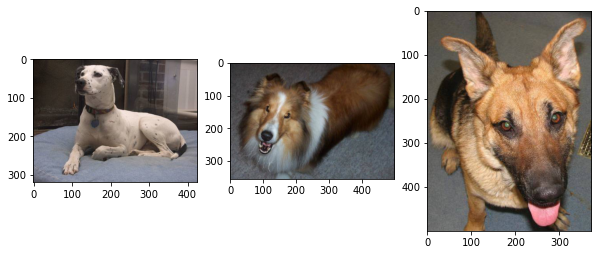

In [53]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))
    
for i in range(3):
    random_filename = random.choice([
        x for x in os.listdir(path)
        if os.path.isfile(os.path.join(path, x))
    ])
    image=imread(path + random_filename)
    globals()['a'+str(i + 1)].imshow(image)

To work with them we need to first proccess them to a format we can make models from. To do so, I will vectorize them, and standartize them to a uniformed size, color etc..

In [2]:
# reading and adding the images and their labels into np arrays
fileNames = os.listdir(path)
filesLength = len(fileNames)

isDogLabel = list() 
dataArray = np.ndarray((filesLength, 7500), dtype=np.uint8)
for i, fileName in enumerate(fileNames): 
    img = cv2.imread(path + fileName) 
    resizedImg = cv2.resize(img, (50,50)) # resizing to a uniform size
    if 'dog' in fileName: # labeling
        isDogLabel.append(1) 
    else:
        isDogLabel.append(0) 
    dataArray[i, :] = resizedImg.flatten()
    if i % 5000 == 0 : 
      print("Processed {} files of {} files.".format(i, filesLength))


Processed 0 files of 25000 files.
Processed 5000 files of 25000 files.
Processed 10000 files of 25000 files.
Processed 15000 files of 25000 files.
Processed 20000 files of 25000 files.


In [3]:
# inserting to a df
data = pd.DataFrame(dataArray, columns= [str(i+1) for i in range(dataArray.shape[1])])
labels = pd.DataFrame({"isDog": isDogLabel})
df = pd.concat([labels, data], axis=1) 
df.reset_index(drop=True, inplace=True)

,isDog,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500
0,0,92,169,208,100,177,216,104,182,225,...,2,0,2,2,0,2,2,0,2,2
1,0,43,43,39,64,58,55,36,40,35,...,71,47,53,70,52,57,75,20,26,39
2,0,53,45,38,61,47,41,64,54,47,...,166,52,150,165,2,183,185,10,183,187
3,0,217,222,221,220,225,224,237,235,235,...,205,208,210,210,218,220,219,207,212,215
4,0,72,109,137,83,120,148,48,87,115,...,96,82,105,120,59,91,102,64,90,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,107,144,148,110,147,151,113,150,154,...,178,132,168,178,134,169,179,135,170,180
24996,1,53,81,111,63,88,114,44,76,95,...,114,50,76,99,66,97,118,37,64,85
24997,1,45,48,53,50,53,58,51,53,54,...,111,134,175,213,27,76,117,126,171,217
24998,1,253,252,253,229,230,253,175,189,235,...,95,98,98,114,97,95,110,107,107,121


## Exploring the Data

In [62]:
print("Dataframe size:" , df.shape)

Dataframe size: (25000, 7501)


In [63]:
df

,isDog,1,2,3,4,5,6,7,8,9,...,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500
0,0,92,169,208,100,177,216,104,182,225,...,2,0,2,2,0,2,2,0,2,2
1,0,43,43,39,64,58,55,36,40,35,...,71,47,53,70,52,57,75,20,26,39
2,0,53,45,38,61,47,41,64,54,47,...,166,52,150,165,2,183,185,10,183,187
3,0,217,222,221,220,225,224,237,235,235,...,205,208,210,210,218,220,219,207,212,215
4,0,72,109,137,83,120,148,48,87,115,...,96,82,105,120,59,91,102,64,90,102


Excluding 'isDog' column, we can see we have 7501 features for each image. Each, describing one pixel.

Now we have a dataframe of our images, vectorized, standatized and ready to work on.
Let see how our vectors outcome:

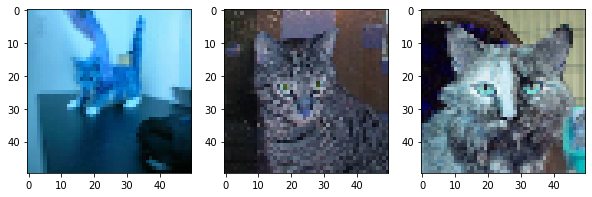

In [51]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))

for i in range(3):
    sample=np.reshape(df[df.columns[1:]].iloc[i].values/255,(50,50,3))
    globals()['a'+str(i + 1)].imshow(sample)

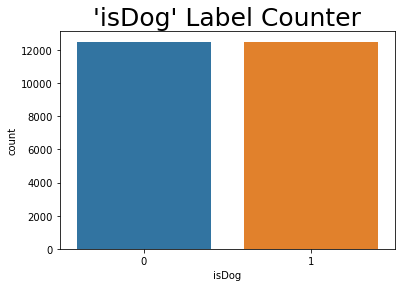

In [70]:
plt.title("'isDog' Label Counter", size=25)
fig = sns.countplot(df.isDog)

#  Modeling without Dimensionality Reduction

As a point of refrence, we will first model witout dimensionality reduction so we can later compare the diffrences.

## Splitting the Data

In [64]:
y = df.isDog
X = df.drop("isDog",axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Modeling with different classifiers

### KNeighborsClassifier

In [74]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knnScore = knn.score(X_test, y_test)*100
print("The KNN model score is: {:.2f}%".format(knnScore))

The KNN model score is: 57.28%


### RandomForestClassifier

In [75]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfcScore = (.score(X_test, y_test)*100
print("The RFC model score is: {:.2f}%".format(rfcScore))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The RFC model score is: 66.20%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


### *--Scores Overview Table--*

To get a clear overview, let's put it all in a summery table:

In [76]:
scores = [
    knnScore,
    rfcScore,
]
scores_df = pd.DataFrame(
    data=scores,
    columns=["Score"],
    index=[
        "KNeighborsClassifier",
        "RandomForestClassifier",
    ],
)
scores_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


,Score
KNeighborsClassifier,57.28
RandomForestClassifier,66.20


#  Modeling with Dimensionality Reduction

## Dimensionality Reduction

Even tough we got nice result's, we might get same or even better results with with less complexed model, which means a lighter, and more accurate model for us.

So let's look for a combination of features that capture well the variance of the original features. 
To do so, we can first look at the explained variance as a function of the number of dimensions:

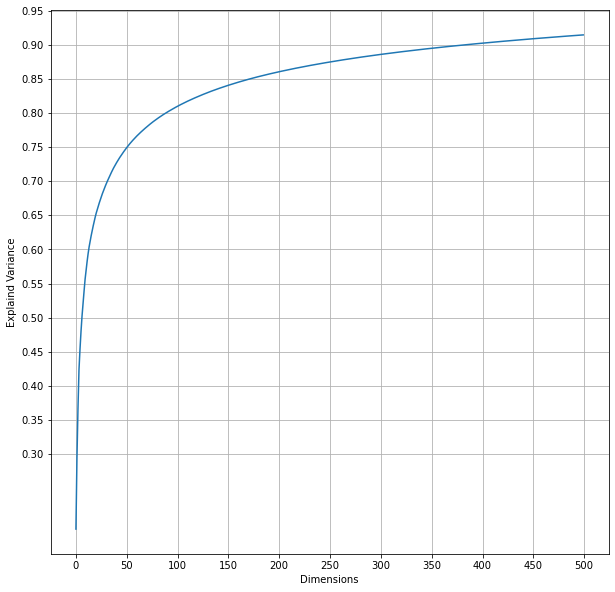

In [80]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_[:500])

plt.figure(figsize=(10,10))
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Explaind Variance")
plt.grid(True)
plt.xticks(range(0,510,50))
plt.yticks(np.arange(0.3,1.0,0.05))
plt.show()

As we can see in the graph, to capture the majority of the variance we with minimum features at least 160 dimensions. To not lose to much of the variance, we will go with enough dimensions to capture 90% of the explained varience.

First, let's see again a sample of the images before the dimensionality reduction:

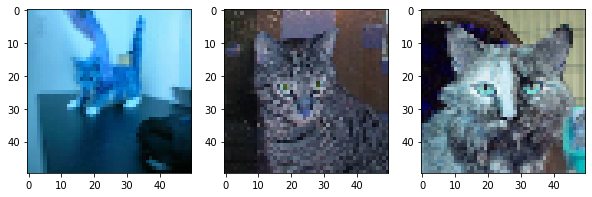

In [95]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))

for i in range(3):
    sample=np.reshape(df[df.columns[1:]].iloc[i].values/255,(50,50,3))
    globals()['a'+str(i + 1)].imshow(sample)

And now, let's reduce and show the reduced images:

In [116]:
pca2= PCA(n_components=600)
X2_reduced = pca2.fit_transform(X_train)
X2_recovered = pca2.inverse_transform(X2_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


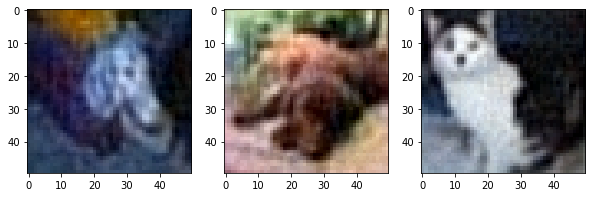

In [117]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))

for i in range(3):
    sample=np.reshape(X2_recovered[i]/255,(50,50,3))
    globals()['a'+str(i + 1)].imshow(sample)

In [113]:
pca= PCA(n_components=0.9)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [118]:
X_test_reduced = pca.transform(X_test)

In [120]:
pca.n_components_

381

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


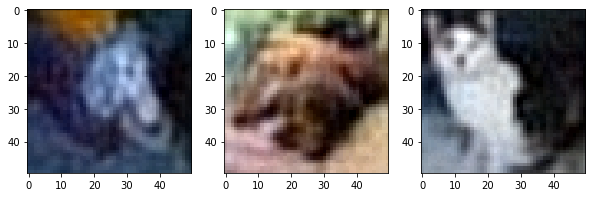

In [114]:
fig, (a1,a2,a3) = plt.subplots(1, 3, figsize = (10,10))

for i in range(3):
    sample=np.reshape(X_recovered[i]/255,(50,50,3))
    globals()['a'+str(i + 1)].imshow(sample)

The reduced images are still somewhat recognizable, we can defenietly move on.

## Splitting the Data

In [124]:
X_reduced_df = pd.DataFrame(
    data = X_reduced,
    columns = [str(i+1) for i in range(381)])

X_test_reduced_df = pd.DataFrame(
    data = X_test_reduced,
    columns = [str(i+1) for i in range(381)])

In [125]:
X_pca_train = X_reduced_df
X_pca_test = X_test_reduced_df
y_pca_train = y_train
y_pca_test = y_test

##  Modeling with different classifiers

### KNeighborsClassifier

In [126]:
knn_pca = KNeighborsClassifier()
knn_pca.fit(X_pca_train,y_pca_train)
knnPcaScore = knn_pca.score(X_pca_test, y_pca_test)*100
print("The KNN model score is: {:.2f}%".format(knnPcaScore))

The KNN model score is: 59.52%


### RandomForestClassifier

In [127]:
rfc_pca = RandomForestClassifier()
rfc_pca.fit(X_pca_train,y_pca_train)
rfcPcaScore = rfc_pca.score(X_pca_test, y_pca_test)*100
print("The RFC model score is: {:.2f}%".format(rfcPcaScore))

The RFC model score is: 60.64%


### AdaBoostClassifier

In [128]:
adb_pca = AdaBoostClassifier()
adb_pca.fit(X_pca_train,y_pca_train)
adbPcaScore = adb_pca.score(X_pca_test, y_pca_test)*100
print("The ADB model score is: {:.2f}%".format(adbPcaScore))

The ADB model score is: 61.68%


### XGBClassifier

In [129]:
xgb_pca = XGBClassifier()
xgb_pca.fit(X_pca_train,y_pca_train)
xgbPcaScore = xgb_pca.score(X_pca_test, y_pca_test)*100
print("The XGB model score is: {:.2f}%".format(xgbPcaScore))

[20:06:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The XGB model score is: 65.50%


### VotingClassifier

In [133]:
vote_pca = VotingClassifier(
    estimators=[('xgb_pca', xgb_pca), ('knn_pca', knn_pca), ('rfc_pca', rfc_pca),], 
    voting='soft'
)
vote_pca.fit(X_pca_train,y_pca_train)
votePcaScore = vote_pca.score(X_pca_test, y_pca_test)*100
print("The Voting model score is: {:.2f}%".format(votePcaScore))

[20:18:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The Voting model score is: 66.16%


### StackingClassifier

In [134]:
stk_pca = StackingClassifier(
    estimators=[('xgb_pca', xgb_pca), ('knn_pca', knn_pca)], 
    final_estimator = rfc_pca
)
stk_pca.fit(X_pca_train,y_pca_train)
stkPcaScore = stk_pca.score(X_pca_test, y_pca_test)*100
print("The Stacking model score is: {:.2f}%".format(stkPcaScore))

[20:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### *--Scores Overview Table--*

To get a clear overview, let's put it all in a summery table:

In [136]:
scores_pca = [
    knnPcaScore,
    rfcPcaScore,
    adbPcaScore,
    xgbPcaScore,
    votePcaScore,
    stkPcaScore,
]
scores_pca_df = pd.DataFrame(
    data=scores_pca,
    columns=["PCA Score"],
    index=[
        "KNeighborsClassifier",
        "RandomForestClassifier",
        "AdaBoostClassifier",
        "XGBClassifier",
        "VotingClassifier",
        "StackingClassifier",
    ],
)
scores_pca_df

,PCA Score
KNeighborsClassifier,59.52
RandomForestClassifier,60.64
AdaBoostClassifier,61.68
XGBClassifier,65.50
VotingClassifier,66.16
StackingClassifier,57.04


# Conclusion

Looking at the Scores Table and the PCA Scores Table, even we would expect to maybe get the best results from the more "modern" models like XGBoost, actually, the best results were using the RandomForestClassifier model.

But the truly shocking fact is that it got similar results to using the full 784 dimensions, but using only 36 of them - meaning after reducing the dimensions by the PCA in __95__ precent!!

To finish, using the RandomForestClassifier model and PCA method, let's predict on our test data and put it in a clear confusion matrix and classification report:

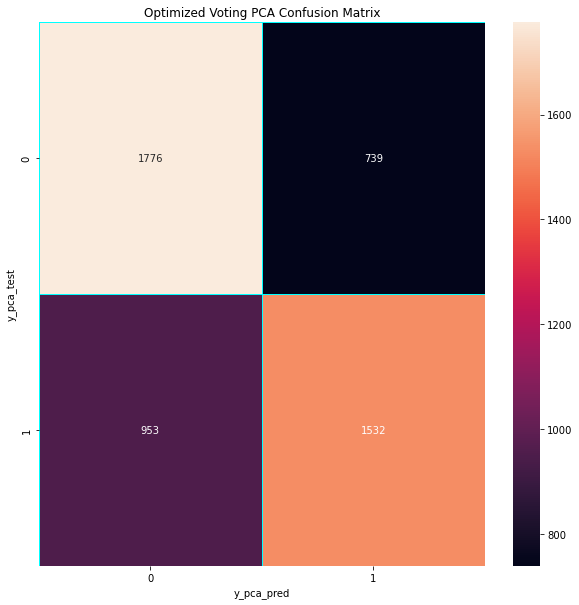

In [142]:
y_pca_pred = vote_pca.predict(X_pca_test)

vote_pca_cm = confusion_matrix(y_pca_test, y_pca_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(vote_pca_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax)
plt.title('Optimized Voting PCA Confusion Matrix')
plt.xlabel('y_pca_pred')
plt.ylabel('y_pca_test')
plt.show()

<AxesSubplot:>

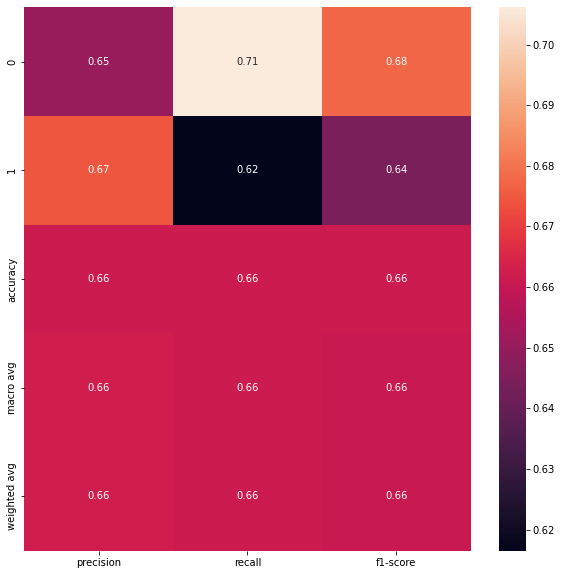

In [141]:
clf_report = classification_report(y_pca_test, y_pca_pred, output_dict=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)